<a href="https://colab.research.google.com/github/apu754/Clasificaci-n-de-Im-genes-con-CNN/blob/main/Clasificaci%C3%B3n_de_Im%C3%A1genes_con_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parcial — Clasificación de Imágenes con CNN


Este cuaderno documenta y ejecuta un pipeline completo de clasificación de imágenes con **CNN** empleando un subconjunto de **Caltech‑101**. La entrega sigue los puntos solicitados en la rúbrica:

**Puntos a cubrir**
1. **Recolección del dataset** (mínimo 2 labels).
2. **Preparación y organización** en `train/`, `val/`, `test` por carpetas de clase (3–10 clases).
3. **Definición de arquitectura CNN** (desde cero o transfer learning).
4. **Aumentación de datos** (si < 200 imágenes/label ⇒ llevar a 300–400).
5. **Entrenamiento y validación** con *accuracy* + **matriz de confusión**.
6. **Guardado del modelo** para reutilización / despliegue (Docker/TF‑Serving).

In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [ ]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")
import os, shutil, zipfile, random, glob, pathlib
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image

from tensorflow_datasets.core.utils.lazy_imports_utils import tensorflow as tf
import tensorflow_datasets.public_api as tfds

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules


if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

## 1) Recolección y 2) Preparación del dataset
- Se utiliza **Caltech‑101** y se seleccionan 5 clases (`Faces_easy`, `Leopards`, `Motorbikes`, `airplanes`, `stop_sign`).
- Estructura estándar usada por Keras:
```
data/
 ├─ train/
 ├─ val/
 └─ test/
```
Cada subcarpeta contiene **carpetas por clase** con sus imágenes.

**Notas**
- `train/` se usa para aprender; `val/` monitorea sobreajuste durante el entrenamiento; `test/` se reserva para la evaluación final.

In [ ]:
# =========================
# 1) Descargar Caltech-101
# =========================
# (Puedes subir el zip a tu Drive; aquí lo bajamos directo del portal)
import urllib.request

url = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1"
zip_path = "/content/caltech-101.zip"
if not os.path.exists(zip_path):
    urllib.request.urlretrieve(url, zip_path)

extract_dir = "/content/caltech-101"
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall("/content")


In [ ]:
import tarfile, os

tar_path = "/content/caltech-101/101_ObjectCategories.tar.gz"
extract_path = "/content/caltech-101"

# Extraer si no existe ya
if not os.path.exists(os.path.join(extract_path, "101_ObjectCategories")):
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=extract_path)

# Ahora ya tienes la carpeta
root = os.path.join(extract_path, "101_ObjectCategories")
print("Clases disponibles:", len(os.listdir(root)))


/tmp/ipython-input-404602891.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


Clases disponibles: 102


In [ ]:
# =========================
# 2) Elegir clases y crear split
# =========================
# Dentro de caltech-101 suele haber carpeta "101_ObjectCategories"
root = "/content/caltech-101/101_ObjectCategories"
all_classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))])

# Elige 5 clases de ejemplo
CLASSES = [
    "airplanes",
    "Motorbikes",
    "Faces_easy",
    "Leopards",
    "stop_sign"
]
print("Usando clases:", CLASSES)

# Crear estructura destino
base_out = "/content/data"
for split in ["train", "val", "test"]:
    for c in CLASSES:
        os.makedirs(os.path.join(base_out, split, c), exist_ok=True)

# Recolectar imágenes por clase y hacer split 70/15/15
train_ratio, val_ratio = 0.70, 0.15
for c in CLASSES:
    imgs = glob.glob(os.path.join(root, c, "*.jpg"))
    random.shuffle(imgs)
    n = len(imgs)
    n_train = int(n*train_ratio)
    n_val   = int(n*val_ratio)
    train_imgs = imgs[:n_train]
    val_imgs   = imgs[n_train:n_train+n_val]
    test_imgs  = imgs[n_train+n_val:]

    def copy_into(files, split):
        for src in files:
            dst = os.path.join(base_out, split, c, os.path.basename(src))
            shutil.copy(src, dst)
    copy_into(train_imgs, "train")
    copy_into(val_imgs,   "val")
    copy_into(test_imgs,  "test")

sum_train = sum(len(os.listdir(os.path.join(base_out,"train",c))) for c in CLASSES)
sum_val   = sum(len(os.listdir(os.path.join(base_out,"val",c))) for c in CLASSES)
sum_test  = sum(len(os.listdir(os.path.join(base_out,"test",c))) for c in CLASSES)
sum_train, sum_val, sum_test


Usando clases: ['airplanes', 'Motorbikes', 'Faces_easy', 'Leopards', 'stop_sign']


(1606, 343, 348)

Clases disponibles: ['stop_sign', 'Faces_easy', 'Motorbikes', 'Leopards', 'airplanes']


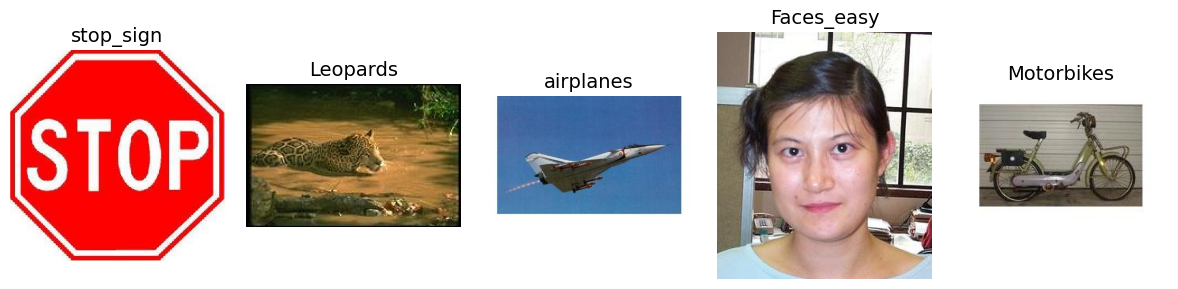

In [ ]:

# Ruta a train/val/test
base_dir = "/content/data/train"

# Elegir clases disponibles dentro de train
classes = os.listdir(base_dir)
print("Clases disponibles:", classes)

# Mostrar algunas imágenes aleatorias de distintas clases
plt.figure(figsize=(12, 8))

for i, c in enumerate(random.sample(classes, min(5, len(classes)))):
    img_files = os.listdir(os.path.join(base_dir, c))
    img_path = os.path.join(base_dir, c, random.choice(img_files))
    img = mpimg.imread(img_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(c)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# --- Conteo por clase en data/train ---
import os

train_dir = "/content/data/train"
valid_ext = (".jpg", ".jpeg", ".png", ".bmp")

classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
counts = {c: sum(1 for f in os.listdir(os.path.join(train_dir, c))
                 if f.lower().endswith(valid_ext))
          for c in classes}

print("Imágenes por clase (train):")
for c in classes:
    print(f"  {c}: {counts[c]}")

under_200 = [(c, n) for c, n in counts.items() if n < 200]
print("\nClases < 200 imágenes:", under_200 if under_200 else "Ninguna ✅")


Imágenes por clase (train):
  Faces_easy: 304
  Leopards: 140
  Motorbikes: 558
  airplanes: 560
  stop_sign: 44

Clases < 200 imágenes: [('Leopards', 140), ('stop_sign', 44)]


## 3) Arquitectura de la CNN (desde cero)
Arquitectura implementada (libre): bloques **Conv2D → BatchNorm → ReLU → MaxPool** y una cabeza **GlobalAveragePooling → Dropout → Dense(softmax)** con `num_classes=5`.

**Motivación de diseño**
- **BatchNorm + ReLU** estabiliza y acelera el entrenamiento.
- **MaxPool** reduce resolución y capta patrones globales.
- **GlobalAveragePooling** evita millones de parámetros de `Flatten + Dense` (reduce *overfitting*).
- **Dropout** regulariza con pocas imágenes por clase.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from functools import partial

tf.random.set_seed(SEED)

# Atajo para convs con ReLU + he_normal
DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=3, padding="same",
                        activation=None,  # activación después de BN
                        use_bias=False,   # no hace falta con BN
                        kernel_initializer="he_normal")

IMG_SIZE = (224, 224)
num_classes = 5

model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),

    # Bloque 1
    layers.Conv2D(64, kernel_size=7, strides=2, padding="same", use_bias=False, kernel_initializer="he_normal"),
    layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPool2D(),

    # Bloque 2
    DefaultConv2D(128), layers.BatchNormalization(), layers.ReLU(),
    DefaultConv2D(128), layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPool2D(),

    # Bloque 3
    DefaultConv2D(256), layers.BatchNormalization(), layers.ReLU(),
    DefaultConv2D(256), layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPool2D(),

    # Cabeza ligera
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")
])

#Resumen
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 256)    │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,119,941 (4.27 MB)

 Trainable params: 1,118,277 (4.27 MB)

 Non-trainable params: 1,664 (6.50 KB)

## 4) Aumentación de datos
- **On‑the‑fly**: flips, rotación, zoom, traslación, contraste (solo en `train`).
- **Offline (en disco)**: para clases con <200 imágenes, se generan aumentadas (rotación ±20°, flip, brillo y contraste) **hasta 400 por clase** en `train/`.
- `val/` y `test/` NO se aumentan para mantener evaluación honesta.

In [ ]:

import os, random
from PIL import Image, ImageEnhance

train_dir = "/content/data/train"
TARGET_PER_CLASS = 400   # meta por clase
valid_ext = (".jpg", ".jpeg", ".png", ".bmp")

def augment_pil(img: Image.Image):
    # Rotación aleatoria
    angle = random.uniform(-20, 20)
    img = img.rotate(angle, resample=Image.BICUBIC, expand=True)

    # Flip horizontal aleatorio
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    # Brillo y contraste
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2))
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.2))
    return img

# Recorremos todas las clases en train
for c in sorted(os.listdir(train_dir)):
    class_dir = os.path.join(train_dir, c)
    if not os.path.isdir(class_dir):
        continue

    files = [f for f in os.listdir(class_dir) if f.lower().endswith(valid_ext)]
    n0 = len(files)

    if n0 >= TARGET_PER_CLASS:
        print(f"{c}: {n0} (ya ok)")
        continue

    idx = 0
    while len([f for f in os.listdir(class_dir) if f.lower().endswith(valid_ext)]) < TARGET_PER_CLASS:
        src = os.path.join(class_dir, random.choice(files))
        with Image.open(src).convert("RGB") as im:
            aug = augment_pil(im)
            out_path = os.path.join(
                class_dir,
                f"{os.path.splitext(os.path.basename(src))[0]}_aug_{idx}.jpg"
            )
            aug.save(out_path, quality=95)
        idx += 1

    n_final = len([f for f in os.listdir(class_dir) if f.lower().endswith(valid_ext)])
    print(f"{c}: {n0} → {n_final} imágenes (aumentado)")




Faces_easy: 304 → 400 imágenes (aumentado)
Leopards: 140 → 400 imágenes (aumentado)
Motorbikes: 558 (ya ok)
airplanes: 560 (ya ok)
stop_sign: 44 → 400 imágenes (aumentado)


Clases disponibles: ['stop_sign', 'Faces_easy', 'Motorbikes', 'Leopards', 'airplanes']


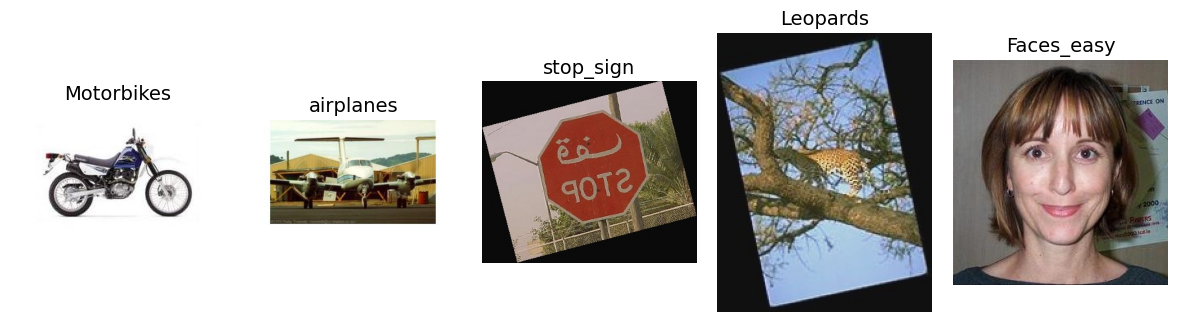

In [ ]:
base_dir = "/content/data/train"

# Elegir clases disponibles dentro de train
classes = os.listdir(base_dir)
print("Clases disponibles:", classes)

# Mostrar algunas imágenes aleatorias de distintas clases
plt.figure(figsize=(12, 8))

for i, c in enumerate(random.sample(classes, min(5, len(classes)))):
    img_files = os.listdir(os.path.join(base_dir, c))
    img_path = os.path.join(base_dir, c, random.choice(img_files))
    img = mpimg.imread(img_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(c)
    plt.axis("off")

plt.tight_layout()
plt.show()

## 5) Entrenamiento, validación y matriz de confusión
Se entrena con **SGD (lr=0.01, momentum=0.9)** y *callbacks*:

- **EarlyStopping** (paciencia 6, restaura mejores pesos).
- **ReduceLROnPlateau** (factor 0.5) → reduce *learning rate* cuando `val_loss` se estanca.
- **ModelCheckpoint** → guarda el mejor modelo en validación.

**Cómo interpretar las métricas** (ejemplo real observado):
- **accuracy (train)**: desempeño en entrenamiento; sube ~0.70 → >0.99 ⇒ aprendizaje efectivo.
- **loss (train)**: error `sparse_categorical_crossentropy`; baja ~0.85 → ~0.02 ⇒ predicciones más confiadas.
- **val_accuracy**: generalización; sube ~0.39 → ~0.98.
- **val_loss**: error en validación; cae ~3.83 → ~0.05.
- **learning_rate**: `ReduceLROnPlateau` ajusta dinámicamente: 0.01 → 0.005 → 0.0025 → 0.0012 para estabilizar.

También se reportan curvas (*accuracy/loss*) y la **matriz de confusión** normalizada por clase.

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224) # tamaño al que se redimensiona cada imagen
BATCH = 32 # número de imágenes por lote
AUTOTUNE = tf.data.AUTOTUNE # deja que TF optimice el paralelismo

train_dir = "/content/data/train"
val_dir   = "/content/data/val"
test_dir  = "/content/data/test"

# 1) Cargar datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="int",
    shuffle=True,
    seed=SEED
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="int",
    shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="int",
    shuffle=False
)

# 2) Nombres de clases detectados (tomados de las carpetas)
class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)

# 3) Data augmentation (on-the-fly)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.RandomContrast(0.1),
], name="augmentation")

# 4) Preprocesamiento (reescala a [0,1])
def prep(ds, training=False):
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.cache().shuffle(1000).prefetch(AUTOTUNE) if training else ds.cache().prefetch(AUTOTUNE)

train_ds2 = prep(train_ds, training=True)
val_ds2   = prep(val_ds, training=False)
test_ds2  = prep(test_ds, training=False)


Found 2318 files belonging to 5 classes.
Found 343 files belonging to 5 classes.
Found 348 files belonging to 5 classes.
Clases: ['Faces_easy', 'Leopards', 'Motorbikes', 'airplanes', 'stop_sign']


Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 58s 183ms/step - accuracy: 0.6965 - loss: 0.8547 - val_accuracy: 0.3965 - val_loss: 3.8309 - learning_rate: 0.0100
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8893 - loss: 0.3180 - val_accuracy: 0.7988 - val_loss: 0.6519 - learning_rate: 0.0100
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9317 - loss: 0.2126 - val_accuracy: 0.8980 - val_loss: 0.2956 - learning_rate: 0.0100
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9335 - loss: 0.2065 - val_accuracy: 0.5569 - val_loss: 1.6766 - learning_rate: 0.0100
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9501 - loss: 0.1631 - val_accuracy: 0.8892 - val_loss: 0.3092 - learning_rate: 0.0100
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9552 - loss: 0.1351 - val_accuracy: 0.7114 - val_loss: 1.0346 - learning_rate: 0.0100
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9563 - loss: 0.1214 - val_a

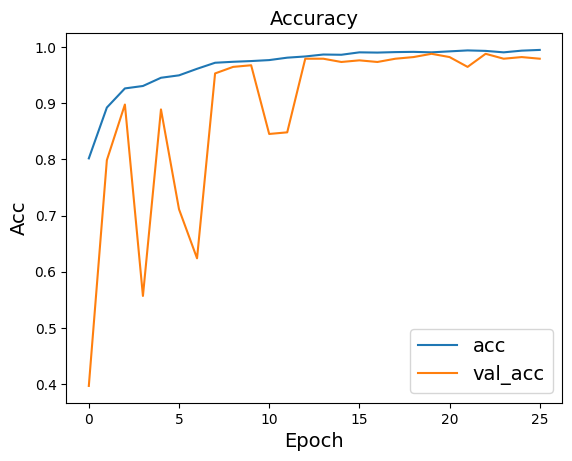

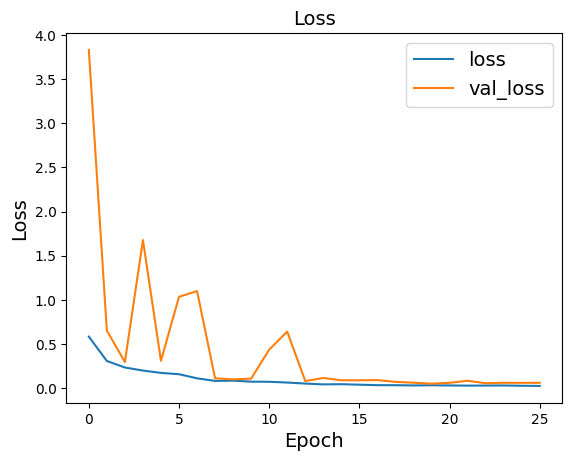

Test accuracy: 0.9828

Classification report:

              precision    recall  f1-score   support

  Faces_easy       1.00      0.97      0.98        66
    Leopards       0.96      0.90      0.93        30
  Motorbikes       0.98      0.99      0.99       121
   airplanes       0.98      1.00      0.99       120
   stop_sign       0.92      1.00      0.96        11

    accuracy                           0.98       348
   macro avg       0.97      0.97      0.97       348
weighted avg       0.98      0.98      0.98       348



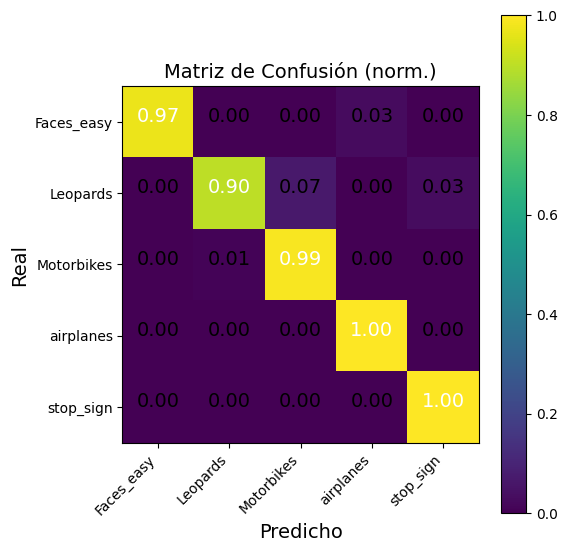

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# 1) Compilar
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

# 2) Entrenar con callbacks útiles
EPOCHS = 30
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True),
]

history = model.fit(
    train_ds2,
    validation_data=val_ds2,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1 # 0=silencio, 1=barra detallada, 2=una línea por epoch
)

# 3) Curvas de entrenamiento
plt.figure()
plt.plot(history.history["accuracy"], label="acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend(); plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# 4) Evaluación en test
test_loss, test_acc = model.evaluate(test_ds2, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

# 5) Matriz de confusión + classification report
y_true, y_pred = [], []
for xb, yb in test_ds2:
    p = model.predict(xb, verbose=0)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(np.argmax(p, axis=1).tolist())

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, normalize=True):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Matriz de Confusión' + (' (norm.)' if normalize else ''))
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45, ha="right")
    plt.yticks(ticks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Real'); plt.xlabel('Predicho'); plt.tight_layout()

plot_confusion_matrix(cm, class_names, normalize=True)
plt.show()


“En esta gráfica vemos cómo la precisión de entrenamiento (azul) sube de manera constante, mientras que la precisión de validación (naranja) empieza inestable pero luego se estabiliza y se acerca mucho a la azul. Eso significa que el modelo no solo memorizó los datos de entrenamiento, sino que también generaliza bien a datos nuevos. Los saltos de validación en las primeras épocas son normales porque el modelo todavía estaba ajustando sus parámetros.”

“En esta gráfica vemos cómo la pérdida baja en cada época. Eso significa que el modelo no solo acierta más, sino que lo hace con más seguridad. Por ejemplo, en la primera época podía predecir ‘40% gato, 60% perro’, pero después de entrenar más acaba prediciendo ‘95% gato, 5% perro’. Esa diferencia de confianza es lo que hace que la loss disminuya, aunque la accuracy ya sea alta.”

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step


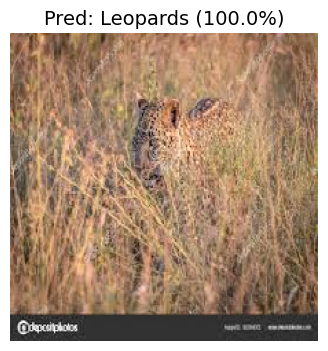

Top-3 predicciones:
  Leopards        100.0%
  Faces_easy        0.0%
  Motorbikes        0.0%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# --- 1) Cargar y preprocesar igual que en tu pipeline (x/255.0) ---
img_path = "/content/leopard.jpeg"   # <-- tu imagen
img = image.load_img(img_path, target_size=(224, 224))    # reescalar como en train
img_array = image.img_to_array(img).astype("float32") / 255.0
x = np.expand_dims(img_array, axis=0)                     # (1,224,224,3)

# --- 2) Predecir ---
probs = model.predict(x)[0]            # vector de probabilidades (num_classes,)
pred_idx = int(np.argmax(probs))
pred_cls = class_names[pred_idx]
pred_pct = float(probs[pred_idx] * 100)

# --- 3) Mostrar imagen con etiqueta y porcentaje ---
plt.figure(figsize=(4,4))
plt.imshow(img_array)                  # ya está en [0,1]
plt.title(f"Pred: {pred_cls} ({pred_pct:.1f}%)")
plt.axis("off")
plt.show()

# --- 4) (Opcional) Top-3 clases con porcentajes ---
topK = 3
top_idx = probs.argsort()[-topK:][::-1]
print("Top-3 predicciones:")
for i in top_idx:
    print(f"  {class_names[i]:<15} {probs[i]*100:5.1f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


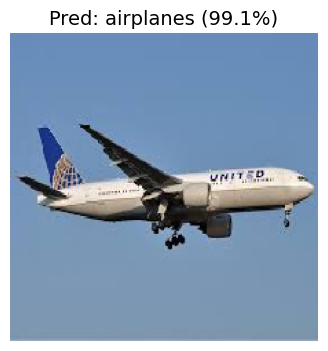

Top-3 predicciones:
  airplanes        99.1%
  Leopards          0.9%
  stop_sign         0.0%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# --- 1) Cargar y preprocesar igual que en tu pipeline (x/255.0) ---
img_path = "/content/images (1).jpeg"   # <-- tu imagen
img = image.load_img(img_path, target_size=(224, 224))    # reescalar como en train
img_array = image.img_to_array(img).astype("float32") / 255.0
x = np.expand_dims(img_array, axis=0)                     # (1,224,224,3)

# --- 2) Predecir ---
probs = model.predict(x)[0]            # vector de probabilidades (num_classes,)
pred_idx = int(np.argmax(probs))
pred_cls = class_names[pred_idx]
pred_pct = float(probs[pred_idx] * 100)

# --- 3) Mostrar imagen con etiqueta y porcentaje ---
plt.figure(figsize=(4,4))
plt.imshow(img_array)                  # ya está en [0,1]
plt.title(f"Pred: {pred_cls} ({pred_pct:.1f}%)")
plt.axis("off")
plt.show()

# --- 4) (Opcional) Top-3 clases con porcentajes ---
topK = 3
top_idx = probs.argsort()[-topK:][::-1]
print("Top-3 predicciones:")
for i in top_idx:
    print(f"  {class_names[i]:<15} {probs[i]*100:5.1f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


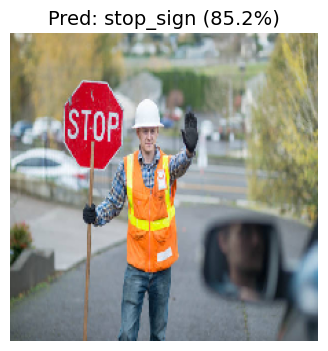

Top-3 predicciones:
  stop_sign        85.2%
  airplanes         6.3%
  Faces_easy        5.4%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# --- 1) Cargar y preprocesar igual que en tu pipeline (x/255.0) ---
img_path = "/content/istockphoto-672690216-612x612.jpg"   # <-- tu imagen
img = image.load_img(img_path, target_size=(224, 224))    # reescalar como en train
img_array = image.img_to_array(img).astype("float32") / 255.0
x = np.expand_dims(img_array, axis=0)                     # (1,224,224,3)

# --- 2) Predecir ---
probs = model.predict(x)[0]            # vector de probabilidades (num_classes,)
pred_idx = int(np.argmax(probs))
pred_cls = class_names[pred_idx]
pred_pct = float(probs[pred_idx] * 100)

# --- 3) Mostrar imagen con etiqueta y porcentaje ---
plt.figure(figsize=(4,4))
plt.imshow(img_array)                  # ya está en [0,1]
plt.title(f"Pred: {pred_cls} ({pred_pct:.1f}%)")
plt.axis("off")
plt.show()

# --- 4) (Opcional) Top-3 clases con porcentajes ---
topK = 3
top_idx = probs.argsort()[-topK:][::-1]
print("Top-3 predicciones:")
for i in top_idx:
    print(f"  {class_names[i]:<15} {probs[i]*100:5.1f}%")

# **Guardar modelo**

In [ ]:
import os, json, tensorflow as tf

# --- 1) Guardar en formato Keras (.keras) ---
tf.keras.models.save_model(model, "model_cnn.keras")  # o model.save("model_cnn.keras")

# --- 2) Guardar SavedModel (para TF Serving) ---
savedmodel_dir = "/content/savedmodel/1"
os.makedirs(os.path.dirname(savedmodel_dir), exist_ok=True)

# Keras 3: usar model.export()
if hasattr(model, "export"):
    model.export(savedmodel_dir)    # crea un SavedModel servible en esa ruta
else:
    # Keras 2.x / TF2.15: estas dos opciones funcionan
    # Opción A
    tf.keras.models.save_model(model, savedmodel_dir, save_format="tf")
    # Opción B (equivalente)
    # tf.saved_model.save(model, savedmodel_dir)

# --- 3) Guardar las clases ---
with open("class_names.json", "w") as f:
    json.dump(class_names, f, ensure_ascii=False, indent=2)

print("OK: guardado .keras, SavedModel y class_names.json")


Saved artifact at '/content/savedmodel/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138424592916432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138424592918928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138424592919504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138424592918352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138424592919120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138424592919312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138424592918544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138424592916624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138424592920464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138424592919888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138424592